<a href="https://colab.research.google.com/github/carlosinator/cil-sentiment/blob/main/accuracy_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports & Setup

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
%%bash
pip3 install transformers emoji==0.6.0 keras_nlp

In [ ]:
!git clone https://github.com/carlosinator/cil-sentiment.git

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras_nlp
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
import transformers
from transformers import AutoTokenizer, TFAutoModel, AutoConfig, TFAutoModelForSequenceClassification
import matplotlib.pyplot as plt
import pickle
import re
import subprocess as sp
import os
from threading import Thread , Timer
import sched, time

import sys
sys.path.append("./cil-sentiment/models")
sys.path.append("./cil-sentiment/")
from gru_models import GRUModel, VGRUModel
import utils

# reproducibility
transformers.set_seed(0) # sets the seed in random, numpy, and tf

In [ ]:
!gsutil cp "gs://cil_2023/train_pos_full_preprocessed_without_duplicates.txt" .
!gsutil cp "gs://cil_2023/train_neg_full_preprocessed_without_duplicates.txt" .

model_name = "vinai/bertweet-base"
filename_train_pos = "train_pos_full_preprocessed_without_duplicates.txt"
filename_train_neg = "train_neg_full_preprocessed_without_duplicates.txt"

# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

In [ ]:
# read dataset
dataset_pos_pd = pd.read_table(filename_train_pos, sep='\r\n', header=None, names=['text'])
dataset_neg_pd = pd.read_table(filename_train_neg, sep='\r\n', header=None, names=['text'])
dataset_pos_pd['label'] = 0
dataset_neg_pd['label'] = 1
dataset_pd = pd.concat([dataset_pos_pd, dataset_neg_pd])

# shuffle
dataset_pd = dataset_pd.sample(frac=1, random_state=0).reset_index(drop=True)

# tokenize data set
tokenizer = AutoTokenizer.from_pretrained(model_name)
texts = tokenizer.batch_encode_plus(dataset_pd['text'].tolist(),
                                    padding=True, truncation=True,
                                    return_tensors='tf')

dataset = tf.data.Dataset.from_tensor_slices((dict(texts), dataset_pd['label']))

# split training / validation
batch_size = 1024 # * tpu_strategy.num_replicas_in_sync
AUTOTUNE = tf.data.experimental.AUTOTUNE

val_data_size = int(0.1 * len(dataset_pd.index))
test_data_size = int(0.1 * len(dataset_pd.index))
train_data_size = len(dataset_pd.index) - val_data_size - test_data_size
val_ds = dataset.take(val_data_size).batch(batch_size, drop_remainder=True)
test_ds = dataset.take(test_data_size).batch(batch_size, drop_remainder=True)
train_ds = dataset.skip(val_data_size).batch(batch_size, drop_remainder=True)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

# Load in Model

In [ ]:
USE_MODEL = "read" # alternatively 'read' or 'read-var'

run_name = "inference_" + USE_MODEL + "_fullmodel"
!gsutil cp -r {"gs://cil_2023/models/" + run_name} .

model = tf.keras.models.load_model(run_name)

In [ ]:
model.predict(test_ds)

In [ ]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score

# Assuming that 'model' is your trained model
# Assuming that 'dataset' is your batched dataset

# These lists will store all labels and predictions
all_labels = []
all_predictions = []

# Iterate over batches in the dataset
for features, labels in test_ds:
    # Predict the outputs for the current batch
    batch_predictions = model.predict(features)
    # Flatten labels and add them to their respective lists
    all_labels.extend(labels.numpy().flatten())
    # Save the batch predictions
    all_predictions.extend(batch_predictions)

# Convert list of predictions to numpy array
all_predictions = np.array(all_predictions)

# Use argmax to get the class with the highest probability for each prediction
all_predictions_labels = np.argmax(all_predictions, axis=-1)

# Now we can compute the accuracy and F1 score
accuracy = accuracy_score(all_labels, all_predictions_labels)
f1 = f1_score(all_labels, all_predictions_labels, average='macro')

print("Model accuracy:", accuracy)
print("Model F1 score:", f1)


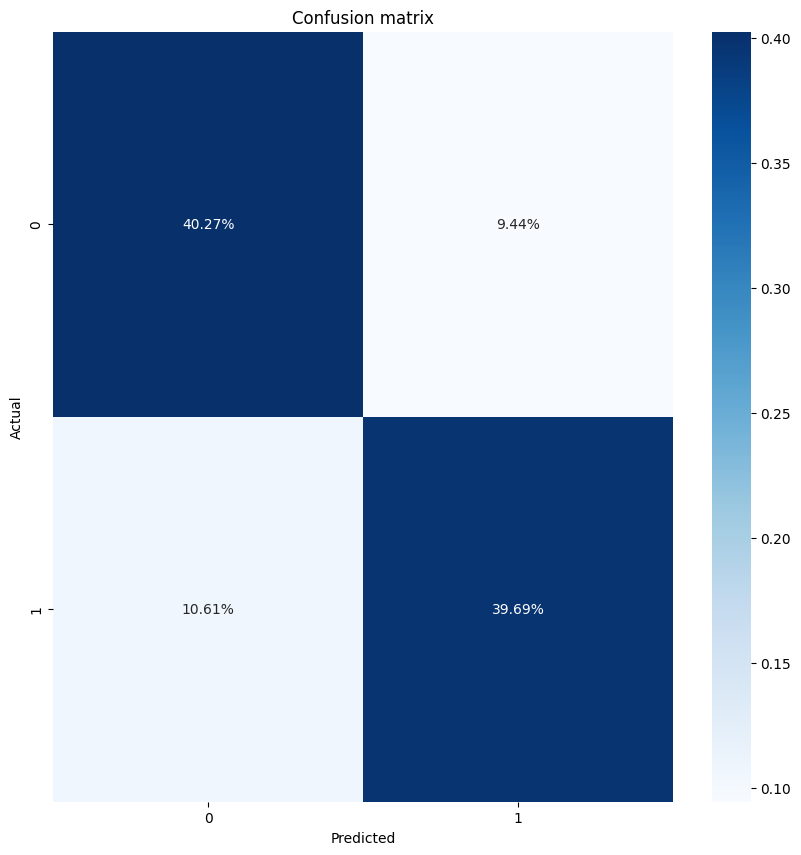

In [36]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions_labels)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()
